<a href="https://colab.research.google.com/github/tzstzstzs/INLP_project/blob/master/NLP_projekt_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets
!pip install --upgrade datasets transformers fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

def train_and_evaluate_model(model_name, dataset, output_dir):
    # Construct the full path within Google Drive
    drive_output_dir = os.path.join('/content/drive/MyDrive/', output_dir)

    # Check if model and tokenizer already exist in Google Drive
    if os.path.exists(drive_output_dir) and os.path.exists(os.path.join(drive_output_dir, 'config.json')) \
    and os.path.exists(os.path.join(drive_output_dir, 'tokenizer_config.json')):
        print(f"Loading existing model from {drive_output_dir}")
        tokenizer = AutoTokenizer.from_pretrained(drive_output_dir)
        model = AutoModelForSequenceClassification.from_pretrained(drive_output_dir)
    else:
        print(f"Training new model and saving to {drive_output_dir}")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

        def preprocess_function(examples):
            return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

        tokenized_datasets = dataset.map(preprocess_function, batched=True)

        training_args = TrainingArguments(
            output_dir=drive_output_dir,
            report_to="none",
            eval_strategy="epoch",
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=2,
            weight_decay=0.01,
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"].shuffle(seed=42).select(range(1000)),
            eval_dataset=tokenized_datasets["test"].shuffle(seed=42).select(range(500)),
        )

        trainer.train()

        # Create the output directory in Google Drive if it doesn't exist
        os.makedirs(drive_output_dir, exist_ok=True)

        trainer.save_model(drive_output_dir)
        tokenizer.save_pretrained(drive_output_dir)

    # Evaluation part
    def preprocess_function(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)

    tokenized_datasets = dataset.map(preprocess_function, batched=True)

    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir=drive_output_dir, report_to="none"),
        eval_dataset=tokenized_datasets["test"].shuffle(seed=42).select(range(500)),
    )


    eval_result = trainer.evaluate()
    predictions = trainer.predict(tokenized_datasets["test"].shuffle(seed=42).select(range(500)))
    predicted_labels = predictions.predictions.argmax(-1)
    true_labels = predictions.label_ids
    eval_result['eval_accuracy'] = accuracy_score(true_labels, predicted_labels)
    eval_result['eval_f1'] = f1_score(true_labels, predicted_labels, average='weighted')
    eval_result['eval_auc'] = roc_auc_score(true_labels, predictions.predictions[:, 1])

    return eval_result

Mounted at /content/drive


In [3]:
# Load datasets
dataset1 = load_dataset("imdb")
dataset2 = load_dataset("rotten_tomatoes")

# Define model names and output directories (relative to MyDrive/)
model_names = ["distilbert-base-uncased", "bert-base-uncased", "roberta-base"]
output_dirs = ["my_distilbert_model", "my_bert_model", "my_roberta_model"]

# Train and evaluate models on both datasets, saving the models
results = []
for model_name, output_dir in zip(model_names, output_dirs):
    eval_result1 = train_and_evaluate_model(model_name, dataset1, output_dir + "_imdb")
    eval_result2 = train_and_evaluate_model(model_name, dataset2, output_dir + "_rotten_tomatoes")
    results.append({
        "model_name": model_name,
        "eval_result1": eval_result1,
        "eval_result2": eval_result2,
    })

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Loading existing model from /content/drive/MyDrive/my_distilbert_model_imdb


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loading existing model from /content/drive/MyDrive/my_distilbert_model_rotten_tomatoes


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Loading existing model from /content/drive/MyDrive/my_bert_model_imdb


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loading existing model from /content/drive/MyDrive/my_bert_model_rotten_tomatoes


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Loading existing model from /content/drive/MyDrive/my_roberta_model_imdb


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Loading existing model from /content/drive/MyDrive/my_roberta_model_rotten_tomatoes


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [4]:
# Create DataFrame for comparison
metrics = ['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_auc', 'eval_runtime']
results_data = []
for result in results:
    results_data.append({
        'Model': result['model_name'],
        **{f'{metric}_imdb': result['eval_result1'].get(metric) for metric in metrics},
        **{f'{metric}_rotten_tomatoes': result['eval_result2'].get(metric) for metric in metrics},
    })

results_df = pd.DataFrame(results_data)

# Display the DataFrame with differences
display(results_df)

,Model,eval_loss_imdb,eval_accuracy_imdb,eval_f1_imdb,eval_auc_imdb,eval_runtime_imdb,eval_loss_rotten_tomatoes,eval_accuracy_rotten_tomatoes,eval_f1_rotten_tomatoes,eval_auc_rotten_tomatoes,eval_runtime_rotten_tomatoes
0,distilbert-base-uncased,0.401953,0.826,0.826010,0.910985,2.4345,0.505697,0.798,0.797500,0.878503,1.6451
1,bert-base-uncased,0.364880,0.862,0.861809,0.926989,3.2874,0.399095,0.848,0.847070,0.903226,3.2820
2,roberta-base,0.387581,0.844,0.844007,0.923164,3.3663,0.408203,0.820,0.817738,0.911890,3.1953


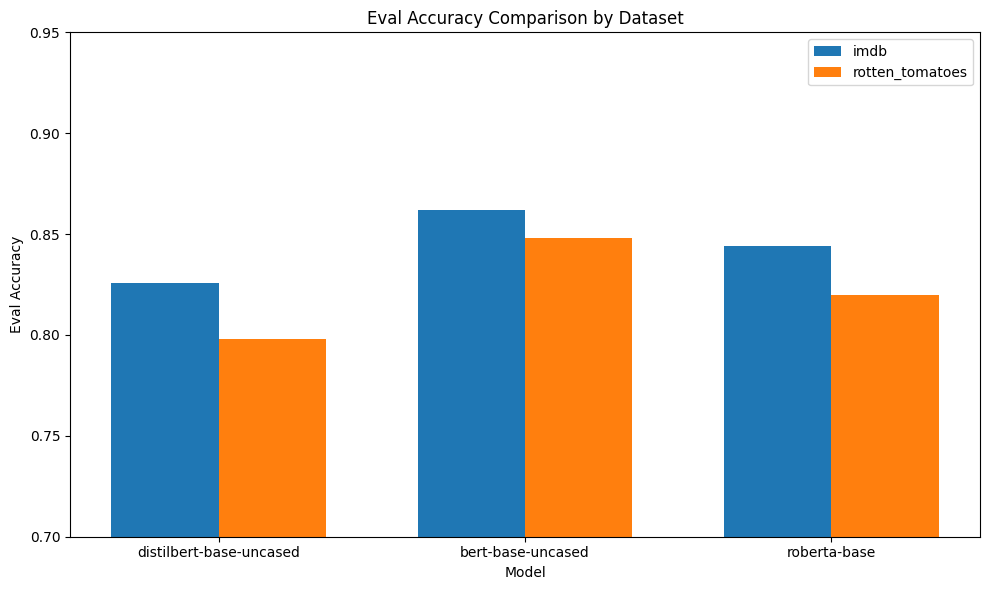

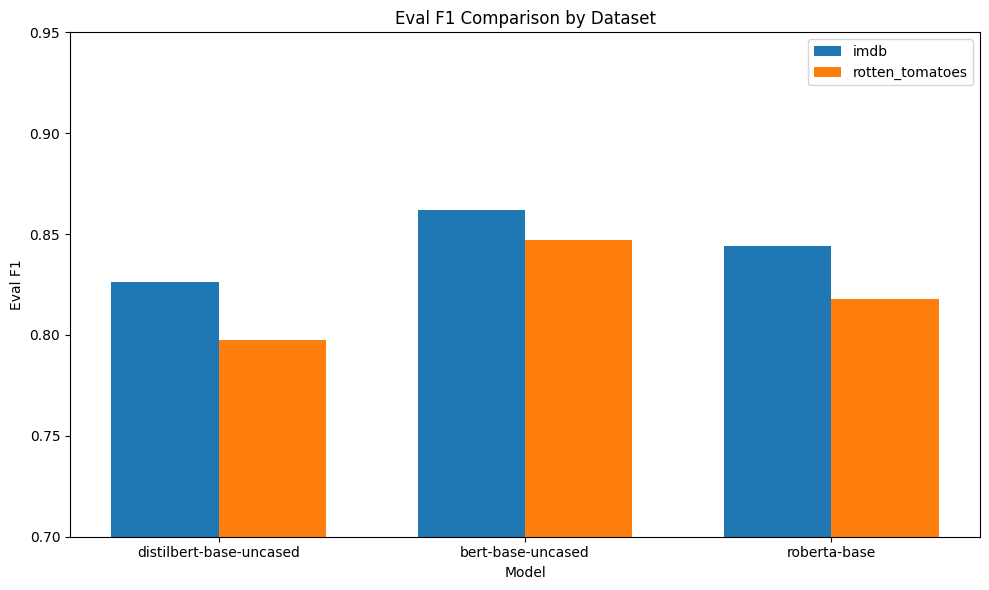

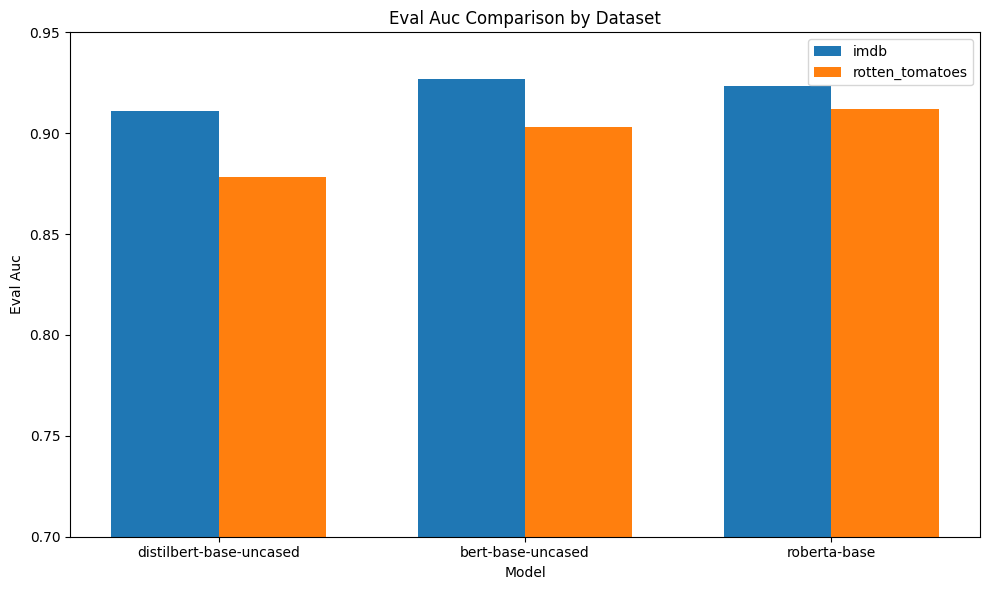

In [5]:
import matplotlib.pyplot as plt
import pandas as pd



metrics = ['eval_accuracy', 'eval_f1', 'eval_auc']
datasets = ['imdb', 'rotten_tomatoes']

for metric in metrics:
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(results_df['Model']))

    for i, dataset in enumerate(datasets):
        ax.bar([p + bar_width * i for p in index], results_df[f'{metric}_{dataset}'], bar_width, label=dataset)

    ax.set_xlabel('Model')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} Comparison by Dataset')
    ax.set_xticks([p + bar_width / 2 for p in index])
    ax.set_xticklabels(results_df['Model'])
    ax.legend()

    # Set the y-axis limits
    ax.set_ylim(0.7, 0.95) # Set lower limit to 0.6 and upper limit to 1.0 (for metrics between 0 and 1)

    plt.tight_layout()
    plt.show()

## Text for the chat to test the model:

**✅ 1. Positive**

"I absolutely loved this movie! The story was captivating and the performances were outstanding."


**❌ 2. Negative**

"This was one of the worst films I've seen. The plot made no sense and the acting was terrible."


**⚖️ 3. Neutral, but slightly positive (challenging)**

"It wasn’t perfect, but I found it enjoyable overall and would probably watch it again."

**⚖️ 4. Neutral, but slightly negative (challenging)**

"The movie had a few interesting moments, but overall it felt too slow and uninspired."


**✅ 5. Ambiguous Sentiment**
Test borderline or contradictory opinions that may confuse the model:

"The actors did their best with a terrible script."

"I expected more, but it wasn’t entirely bad."

**✅ 6. Sarcasm and Irony**

"Oh great, another movie about saving the world. Just what we needed."

"Fantastic... if you enjoy falling asleep halfway through."

**✅ 7. Mixed Sentiment**
Include both strong positive and negative signals:

"The visuals were amazing, but the storyline was a disaster."

"Horrible pacing, yet I couldn’t stop watching because of the lead actor’s performance."

**✅ 8. Short and Vague Reviews**

"Not bad." (Positive or neutral?)

"It was fine." (Very ambiguous.)

**✅ 9. Highly Emotional vs. Flat Tone**

"This movie completely changed my life!" (Clearly positive and emotional)

"This film runs for 120 minutes and contains scenes of dialogue." (Neutral)

**✅ 10. Domain-Specific or Off-topic Language**
Test for generalization beyond typical review words:

"As a cinematographer, I appreciated the dynamic lighting choices."

"This reminded me of 90s European art films."

**✅ 11. Typos and Informal Language**

"I rly enjoyed this movy, gr8 job!!"

"It was meh. Not my typa thing."

**✅ 12. Foreign Words / Code-Switching**

"This movie was so chill, nagyon tetszett!"

"Not bad, but la musique was distracting."




In [6]:
# Define the list of test reviews
test_reviews = [
    "I absolutely loved this movie! The story was captivating and the performances were outstanding.",
    "This was one of the worst films I've seen. The plot made no sense and the acting was terrible.",
    "It wasn’t perfect, but I found it enjoyable overall and would probably watch it again.",
    "The movie had a few interesting moments, but overall it felt too slow and uninspired.",
    "The actors did their best with a terrible script.",
    "I expected more, but it wasn’t entirely bad.",
    "Oh great, another movie about saving the world. Just what we needed.",
    "Fantastic... if you enjoy falling asleep halfway through.",
    "The visuals were amazing, but the storyline was a disaster.",
    "Horrible pacing, yet I couldn’t stop watching because of the lead actor’s performance.",
    "Not bad.",
    "It was fine.",
    "This movie completely changed my life!",
    "This film runs for 120 minutes and contains scenes of dialogue.",
    "As a cinematographer, I appreciated the dynamic lighting choices.",
    "This reminded me of 90s European art films.",
    "I rly enjoyed this movy, gr8 job!!",
    "It was meh. Not my typa thing.",
    "This movie was so chill, nagyon tetszett!",
    "Not bad, but la musique was distracting."
]

# Function to load the trained model and tokenizer
def load_sentiment_model(model_path):
    """Loads a trained sentiment analysis model and tokenizer."""
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        return tokenizer, model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None, None

# Function to classify a list of reviews
def classify_reviews(reviews, tokenizer, model):
    """Classifies a list of reviews using the provided model and tokenizer."""
    results = []
    for review in reviews:
        inputs = tokenizer(review, truncation=True, padding='max_length', max_length=128, return_tensors="pt")
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(-1)
        sentiment = "Positive" if predictions.item() == 1 else "Negative"
        results.append({"review": review, "sentiment": sentiment})
    return results

# --- Main Program Flow ---

print("Welcome to the Review Sentiment Classifier!")
print("Choose an option:")
print("1. Run Automated Tests")
print("2. Start User Chat Agent")
print("3. Exit")

while True:
    choice = input("Enter your choice (1, 2, or 3): ")

    if choice == '1':
        # --- Automated Testing ---
        print("\nRunning Automated Tests...\n")

        # Load the trained BERT model for IMDB dataset
        model_path = "/content/drive/MyDrive/my_bert_model_imdb"
        tokenizer, model = load_sentiment_model(model_path)

        if tokenizer and model:
            automated_test_results = classify_reviews(test_reviews, tokenizer, model)
            for result in automated_test_results:
                print(f"Processing review: \"{result['review']}\"")
                print(f"Sentiment: {result['sentiment']}\n")
        else:
            print("Skipping automated testing due to model loading error.")

    elif choice == '2':
        # --- User Chat Agent ---
        print("\nStarting User Chat Agent...")
        print("Type your review or 'quit' to exit.")

        # Load the trained BERT model for IMDB dataset
        model_path = "/content/drive/MyDrive/my_bert_model_imdb"
        tokenizer, model = load_sentiment_model(model_path)

        if tokenizer and model:
            while True:
                user_review = input("Enter your review: ")
                if user_review.lower() == 'quit':
                    break
                # Classify a single review by putting it in a list
                chat_result = classify_reviews([user_review], tokenizer, model)
                print(f"Sentiment: {chat_result[0]['sentiment']}")
        else:
            print("Skipping chat agent due to model loading error.")

    elif choice == '3':
        print("Exiting program.")
        break

    else:
        print("Invalid choice. Please enter 1, 2, or 3.")

print("Program finished.")

Welcome to the Review Sentiment Classifier!
Choose an option:
1. Run Automated Tests
2. Start User Chat Agent
3. Exit
Enter your choice (1, 2, or 3): 2

Starting User Chat Agent...
Type your review or 'quit' to exit.
Enter your review: It was quite good
Sentiment: Positive
Enter your review: It was long and boring
Sentiment: Negative
Enter your review: quit
Enter your choice (1, 2, or 3): 1

Running Automated Tests...

Processing review: "I absolutely loved this movie! The story was captivating and the performances were outstanding."
Sentiment: Positive

Processing review: "This was one of the worst films I've seen. The plot made no sense and the acting was terrible."
Sentiment: Negative

Processing review: "It wasn’t perfect, but I found it enjoyable overall and would probably watch it again."
Sentiment: Positive

Processing review: "The movie had a few interesting moments, but overall it felt too slow and uninspired."
Sentiment: Negative

Processing review: "The actors did their best